In [1]:
import pandas as pd

import dms_variants
import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes
# import neutcurve
# from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import matplotlib
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from plotnine import *

_ = theme_set(dms_variants.plotnine_themes.theme_graygrid())

### Get single tidy df for neut runs for <5yo sera

In [3]:
# start with finalized set of neuts, so we can then remove these samples from rough run data
final_1 = pd.read_csv('neut_data/230212_neuts_tidy.csv')
final_2 = pd.read_csv('neut_data/230214_neuts_tidy.csv')

finalized_ped_neuts = pd.concat([final_1, final_2])

In [17]:
rough_run1 = pd.read_csv('neut_data/230208_neuts_tidy_PBS.csv')

# clean up serum column for run that had 1C04 included
rough_run2 = pd.read_csv('neut_data/230210_neuts_tidy.csv')
rough_run2 = rough_run2.loc[rough_run2['serum'] != '1C04']
rough_run2['serum'] = rough_run2['serum'].astype(int)

rough_ped_neuts = pd.concat([rough_run1, rough_run2])

In [37]:
full_neuts = finalized_ped_neuts.merge(rough_ped_neuts,
                                       on=['serum', 'virus', 'replicate', 'concentration'],
                                       how='outer',
                                       indicator=True
                                      )

# get rid of duplicates from rough runs (the right df in this merge)
full_neuts['fraction infectivity'] = full_neuts.apply(
    lambda row: row['fraction infectivity_y'] if row['_merge'] == 'right_only' 
    else row['fraction infectivity_x'], axis=1
)

full_neuts = full_neuts.drop(['fraction infectivity_x', 'fraction infectivity_y', '_merge'], axis=1)

full_neuts = full_neuts.loc[full_neuts['virus'] == 'HK19']

full_neuts

,serum,virus,replicate,concentration,fraction infectivity
0,2388,HK19,1,0.050000,0.065399
1,2388,HK19,1,0.025000,0.033575
2,2388,HK19,1,0.012500,0.037981
3,2388,HK19,1,0.006250,0.097314
4,2388,HK19,1,0.003125,0.272056
...,...,...,...,...,...
668,3976,HK19,1,0.006250,1.141156
669,3976,HK19,1,0.003125,1.249474
670,3976,HK19,1,0.001563,1.154547
671,3976,HK19,1,0.000781,1.143886


In [2]:
neut_data_consolidated = pd.read_csv('neut_data/230309_consolidated_neuts_5yo.csv')

In [3]:
fits = neutcurve.CurveFits(neut_data_consolidated)

In [4]:
ic50s = fits.fitParams(ics=[50])
ic50s['reciprocal'] = ic50s.apply(lambda x: 1/(x['ic50']), axis=1)

ic50s = ic50s.sort_values('reciprocal').reset_index(drop=True)
ic50s['serum'] = ic50s['serum'].astype(str)

ic50s['age_group'] = '0-5'

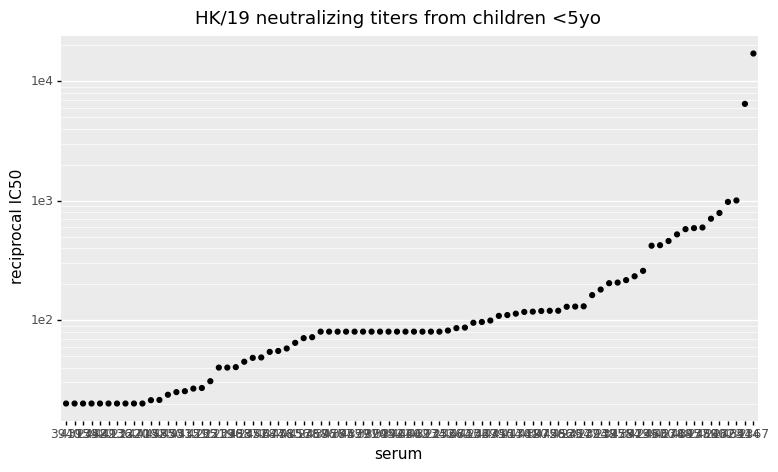

In [22]:
ic50s_filt = ic50s.loc[ic50s['reciprocal'] < 5000]

p = (
    ggplot(
        data=ic50s,
        mapping = aes(x='reorder(serum, reciprocal)', y='reciprocal')) +
    geom_point() +
    theme(figure_size=(9, 5),
         panel_grid_major_x=element_blank(),
         ) +
    scale_y_log10() +
    scale_fill_manual(values=CBPALETTE[1:]) +
    labs(x='serum', 
         y='reciprocal IC50', title='HK/19 neutralizing titers from children <5yo')

)

_ = p.draw()

In [5]:
neut_data_teens = pd.read_csv('neut_data/230303_neuts_tidy.csv')
fits_teens = neutcurve.CurveFits(neut_data_teens)

ic50s_teen = fits_teens.fitParams(ics=[50])
ic50s_teen['reciprocal'] = ic50s_teen.apply(lambda x: 1/(x['ic50']), axis=1)

ic50s_teen = ic50s_teen.sort_values('reciprocal').reset_index(drop=True)
ic50s_teen['serum'] = ic50s_teen['serum'].astype(str)

ic50s_teen['age_group'] = '15-18'

In [6]:
ic50s_full = pd.concat([ic50s, ic50s_teen])
ic50s_full

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom,reciprocal,age_group
0,4136,HK19,average,1,0.050000,lower,>0.05,0.051475,2.087102,1,0,20.000000,0-5
1,2320,HK19,average,1,0.050000,lower,>0.05,0.054636,22.392115,1,0,20.000000,0-5
2,4115,HK19,average,1,0.050000,lower,>0.05,0.059247,1.772875,1,0,20.000000,0-5
3,2322,HK19,average,1,0.050000,lower,>0.05,0.483366,9.977105,1,0,20.000000,0-5
4,4493,HK19,average,1,0.050000,lower,>0.05,0.473468,9.783459,1,0,20.000000,0-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2382,HK19,average,1,0.000743,interpolated,0.000743,0.000743,2.101942,1,0,1345.736343,15-18
28,2343,HK19,average,1,0.000727,interpolated,0.000727,0.000727,2.085529,1,0,1375.822907,15-18
29,2365,HK19,average,1,0.000456,interpolated,0.000456,0.000456,2.162000,1,0,2194.579283,15-18
30,2350,HK19,average,1,0.000391,upper,<0.000391,0.000345,2.574334,1,0,2560.000000,15-18


In [7]:
ic50s_full.to_csv('full_ic50s.csv')

In [2]:
ic50s_full = pd.read_csv('full_ic50s.csv')

In [4]:
p = (
    ggplot(
        data=ic50s_full,
        mapping = aes(x='reorder(serum, reciprocal)', y='reciprocal')) +
    geom_point() +
    theme(figure_size=(12, 4),
         panel_grid_major_x=element_blank(),
         ) +
    scale_y_log10() +
    scale_fill_manual(values=CBPALETTE[1:]) +
    labs(x='serum', 
         y='reciprocal IC50', title='HK/19 neutralizing titers by age group')

)

p = p + facet_wrap('~ age_group', nrow = 1, scales='free_x')
_ = p.draw()

p.save('figures/230309_ped-ic50-summary_test.pdf')

In [ ]:
p = (
    ggplot(
        no_ab_220606_threshold,
        aes(x='no-antibody_count', fill='library')) + 
    geom_histogram(position=position_dodge(), binwidth=0.5) + 
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    scale_fill_manual(values=CBPALETTE[1:]) +
    labs(x='barcode counts', 
         y='number variants', title='distribution of barcode counts for variants below threshold in 220606 no-Ab infection')
) 

_ = p.draw()

In [ ]:
neut_data_pbs = pd.read_csv('neut_data/230208_neuts_tidy_PBS.csv')

# neut_data_pbs['serum'] =neut_data_pbs['serum'].astype(object)

In [ ]:
neut_data_run2 = pd.read_csv('neut_data/230210_neuts_tidy.csv')

# fit with neutcurve package
fits = neutcurve.CurveFits(neut_data_run2)

In [ ]:
neut_data_run3 = pd.read_csv('neut_data/230217_neuts_tidy.csv')

In [ ]:
neut_data_run4 = pd.read_csv('neut_data/230223_neuts_tidy.csv')